In [1]:
import copy
import time
import threading
import pandas as pd
import numpy as np
import more_itertools
import csv
import random
import itertools
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default = 'warn'

In [2]:
df = pd.read_csv('Data/master_rules.csv')
df.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,frozenset({'instant food products'}),frozenset({'soda'}),0.015396,0.313318,0.007955,0.516667,1.649017,0.003131,1.420722
1,frozenset({'instant food products'}),frozenset({'whole milk'}),0.015396,0.458045,0.007955,0.516667,1.127983,0.000903,1.121287
2,frozenset({'uht-milk'}),frozenset({'whole milk'}),0.078522,0.458045,0.040544,0.516340,1.127270,0.004577,1.120529
3,frozenset({'abrasive cleaner'}),frozenset({'rolls/buns'}),0.005645,0.349756,0.002823,0.500000,1.429567,0.000848,1.300488
4,frozenset({'artif. sweetener'}),frozenset({'other vegetables'}),0.007442,0.376700,0.003849,0.517241,1.373086,0.001046,1.291121
5,frozenset({'artif. sweetener'}),frozenset({'whole milk'}),0.007442,0.458045,0.004619,0.620690,1.355085,0.001210,1.428791
6,frozenset({'bathroom cleaner'}),frozenset({'other vegetables'}),0.004362,0.376700,0.002566,0.588235,1.561548,0.000923,1.513729
7,frozenset({'bathroom cleaner'}),frozenset({'whole milk'}),0.004362,0.458045,0.003079,0.705882,1.541078,0.001081,1.842648
8,frozenset({'beef'}),frozenset({'whole milk'}),0.119579,0.458045,0.064152,0.536481,1.171241,0.009379,1.169218
9,frozenset({'bottled beer'}),frozenset({'whole milk'}),0.158840,0.458045,0.085450,0.537964,1.174480,0.012694,1.172973


In [3]:
df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,frozenset({'instant food products'}),frozenset({'soda'}),0.015396,0.313318,0.007955,0.516667,1.649017,0.003131,1.420722
1,frozenset({'instant food products'}),frozenset({'whole milk'}),0.015396,0.458045,0.007955,0.516667,1.127983,0.000903,1.121287
2,frozenset({'uht-milk'}),frozenset({'whole milk'}),0.078522,0.458045,0.040544,0.516340,1.127270,0.004577,1.120529
3,frozenset({'abrasive cleaner'}),frozenset({'rolls/buns'}),0.005645,0.349756,0.002823,0.500000,1.429567,0.000848,1.300488
4,frozenset({'artif. sweetener'}),frozenset({'other vegetables'}),0.007442,0.376700,0.003849,0.517241,1.373086,0.001046,1.291121
...,...,...,...,...,...,...,...,...,...
24247,"frozenset({'other vegetables', 'sausage', 'bot...",frozenset({'root vegetables'}),0.003849,0.230690,0.002566,0.666667,2.889878,0.001678,2.307929
24248,"frozenset({'root vegetables', 'other vegetable...",frozenset({'soda'}),0.003336,0.313318,0.002566,0.769231,2.455112,0.001521,2.975622
24249,"frozenset({'root vegetables', 'other vegetable...",frozenset({'bottled water'}),0.003336,0.213754,0.002566,0.769231,3.598670,0.001853,3.407065
24250,"frozenset({'root vegetables', 'other vegetable...",frozenset({'rolls/buns'}),0.003336,0.349756,0.002566,0.769231,2.199334,0.001399,2.817723


In [4]:
df['consequents'].value_counts()

frozenset({'whole milk'})               10108
frozenset({'other vegetables'})          5942
frozenset({'rolls/buns'})                3672
frozenset({'soda'})                      1894
frozenset({'yogurt'})                    1519
frozenset({'root vegetables'})            294
frozenset({'sausage'})                    212
frozenset({'bottled water'})              202
frozenset({'tropical fruit'})             135
frozenset({'shopping bags'})               64
frozenset({'citrus fruit'})                42
frozenset({'pip fruit'})                   30
frozenset({'pastry'})                      28
frozenset({'canned beer'})                 25
frozenset({'bottled beer'})                18
frozenset({'brown bread'})                 13
frozenset({'pork'})                        12
frozenset({'frankfurter'})                 11
frozenset({'whipped/sour cream'})           9
frozenset({'newspapers'})                   8
frozenset({'domestic eggs'})                3
frozenset({'white bread'})        

In [5]:
df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,frozenset({'instant food products'}),frozenset({'soda'}),0.015396,0.313318,0.007955,0.516667,1.649017,0.003131,1.420722
1,frozenset({'instant food products'}),frozenset({'whole milk'}),0.015396,0.458045,0.007955,0.516667,1.127983,0.000903,1.121287
2,frozenset({'uht-milk'}),frozenset({'whole milk'}),0.078522,0.458045,0.040544,0.516340,1.127270,0.004577,1.120529
3,frozenset({'abrasive cleaner'}),frozenset({'rolls/buns'}),0.005645,0.349756,0.002823,0.500000,1.429567,0.000848,1.300488
4,frozenset({'artif. sweetener'}),frozenset({'other vegetables'}),0.007442,0.376700,0.003849,0.517241,1.373086,0.001046,1.291121
...,...,...,...,...,...,...,...,...,...
24247,"frozenset({'other vegetables', 'sausage', 'bot...",frozenset({'root vegetables'}),0.003849,0.230690,0.002566,0.666667,2.889878,0.001678,2.307929
24248,"frozenset({'root vegetables', 'other vegetable...",frozenset({'soda'}),0.003336,0.313318,0.002566,0.769231,2.455112,0.001521,2.975622
24249,"frozenset({'root vegetables', 'other vegetable...",frozenset({'bottled water'}),0.003336,0.213754,0.002566,0.769231,3.598670,0.001853,3.407065
24250,"frozenset({'root vegetables', 'other vegetable...",frozenset({'rolls/buns'}),0.003336,0.349756,0.002566,0.769231,2.199334,0.001399,2.817723


In [6]:
def fix_frozen_set(x): # takes panda dataframe and reformats antecedents and consequents as Frozensets for correct querying
    beginning = x.find("'") + 1
    end = x.rfind("'")
    data = x[beginning: end]
    data_remove_apostrophes = data.replace("'",'')
    new_data = data_remove_apostrophes.split(',')
    new_data_stripped = []
    for i in range(len(new_data)):
        new_data_stripped.append(copy.copy(new_data[i].strip()))
    if len(new_data_stripped) == 1:
        return frozenset(new_data_stripped)
    else:
        return frozenset([x for x in new_data_stripped])

In [7]:
df['antecedents'] = df['antecedents'].apply(fix_frozen_set)
df['consequents'] = df['consequents'].apply(fix_frozen_set)

In [8]:
df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(instant food products),(soda),0.015396,0.313318,0.007955,0.516667,1.649017,0.003131,1.420722
1,(instant food products),(whole milk),0.015396,0.458045,0.007955,0.516667,1.127983,0.000903,1.121287
2,(uht-milk),(whole milk),0.078522,0.458045,0.040544,0.516340,1.127270,0.004577,1.120529
3,(abrasive cleaner),(rolls/buns),0.005645,0.349756,0.002823,0.500000,1.429567,0.000848,1.300488
4,(artif. sweetener),(other vegetables),0.007442,0.376700,0.003849,0.517241,1.373086,0.001046,1.291121
...,...,...,...,...,...,...,...,...,...
24247,"(sausage, rolls/buns, other vegetables, whole ...",(root vegetables),0.003849,0.230690,0.002566,0.666667,2.889878,0.001678,2.307929
24248,"(sausage, rolls/buns, root vegetables, other v...",(soda),0.003336,0.313318,0.002566,0.769231,2.455112,0.001521,2.975622
24249,"(sausage, rolls/buns, root vegetables, other v...",(bottled water),0.003336,0.213754,0.002566,0.769231,3.598670,0.001853,3.407065
24250,"(sausage, root vegetables, other vegetables, w...",(rolls/buns),0.003336,0.349756,0.002566,0.769231,2.199334,0.001399,2.817723


In [9]:
query = df.iloc[1000:1200,:]

In [10]:
query

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1000,"(frozen vegetables, butter)",(other vegetables),0.012830,0.376700,0.006672,0.520000,1.380409,0.001839,1.298542
1001,"(frozen vegetables, butter)",(whole milk),0.012830,0.458045,0.007442,0.580000,1.266252,0.001565,1.290370
1002,"(butter, fruit/vegetable juice)",(other vegetables),0.019502,0.376700,0.011034,0.565789,1.501963,0.003688,1.435479
1003,"(butter, fruit/vegetable juice)",(whole milk),0.019502,0.458045,0.011291,0.578947,1.263954,0.002358,1.287144
1004,"(butter, grapes)",(other vegetables),0.009238,0.376700,0.004619,0.500000,1.327316,0.001139,1.246600
...,...,...,...,...,...,...,...,...,...
1195,"(herbs, candy)",(whole milk),0.002823,0.458045,0.002566,0.909091,1.984721,0.001273,5.961509
1196,"(candy, ice cream)",(whole milk),0.004362,0.458045,0.002823,0.647059,1.412654,0.000825,1.535540
1197,"(candy, long life bakery product)",(rolls/buns),0.004362,0.349756,0.003079,0.705882,2.018212,0.001554,2.210829
1198,"(candy, margarine)",(other vegetables),0.005645,0.376700,0.003079,0.545455,1.447981,0.000953,1.371260


In [11]:
query.drop(columns=['antecedents','consequents'], inplace=True)
query

,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1000,0.012830,0.376700,0.006672,0.520000,1.380409,0.001839,1.298542
1001,0.012830,0.458045,0.007442,0.580000,1.266252,0.001565,1.290370
1002,0.019502,0.376700,0.011034,0.565789,1.501963,0.003688,1.435479
1003,0.019502,0.458045,0.011291,0.578947,1.263954,0.002358,1.287144
1004,0.009238,0.376700,0.004619,0.500000,1.327316,0.001139,1.246600
...,...,...,...,...,...,...,...
1195,0.002823,0.458045,0.002566,0.909091,1.984721,0.001273,5.961509
1196,0.004362,0.458045,0.002823,0.647059,1.412654,0.000825,1.535540
1197,0.004362,0.349756,0.003079,0.705882,2.018212,0.001554,2.210829
1198,0.005645,0.376700,0.003079,0.545455,1.447981,0.000953,1.371260


In [12]:
column = df.columns[2:]
print(column)
print(type(column))
column1 = list(column)
print(column1)
print(type(column1))

Index(['antecedent support', 'consequent support', 'support', 'confidence',
       'lift', 'leverage', 'conviction'],
      dtype='object')
<class 'pandas.core.indexes.base.Index'>
['antecedent support', 'consequent support', 'support', 'confidence', 'lift', 'leverage', 'conviction']
<class 'list'>


In [13]:
print(type(query))

<class 'pandas.core.frame.DataFrame'>


In [14]:
q_num = query.to_numpy()
print(type(q_num))
print(q_num.size)

<class 'numpy.ndarray'>
1400


In [15]:
query_smaller = query.iloc[:10,:]
query_smaller
# print(type(query_smaller))

,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1000,0.012830,0.376700,0.006672,0.520000,1.380409,0.001839,1.298542
1001,0.012830,0.458045,0.007442,0.580000,1.266252,0.001565,1.290370
1002,0.019502,0.376700,0.011034,0.565789,1.501963,0.003688,1.435479
1003,0.019502,0.458045,0.011291,0.578947,1.263954,0.002358,1.287144
1004,0.009238,0.376700,0.004619,0.500000,1.327316,0.001139,1.246600
1005,0.009238,0.458045,0.005389,0.583333,1.273529,0.001157,1.300693
1006,0.010008,0.458045,0.006415,0.641026,1.399483,0.001831,1.509733
1007,0.009751,0.376700,0.005132,0.526316,1.397175,0.001459,1.315856
1008,0.009751,0.458045,0.005389,0.552632,1.206502,0.000922,1.211430
1009,0.008981,0.376700,0.004619,0.514286,1.365239,0.001236,1.283265


In [16]:
query_smaller.iloc[0]

antecedent support    0.012830
consequent support    0.376700
support               0.006672
confidence            0.520000
lift                  1.380409
leverage              0.001839
conviction            1.298542
Name: 1000, dtype: float64

In [17]:
query_smaller.iloc[0][0]

0.012830382

In [18]:
query_smaller.iloc[0].to_list()

[0.012830382,
 0.376700026,
 0.006671799,
 0.52,
 1.380408719,
 0.001838593,
 1.298541613]

In [19]:
print(type((query_smaller.iloc[0].to_list())[0]))

<class 'float'>


Text(0.5, 0.98, 'ALL OF THE PLOTS!!!')

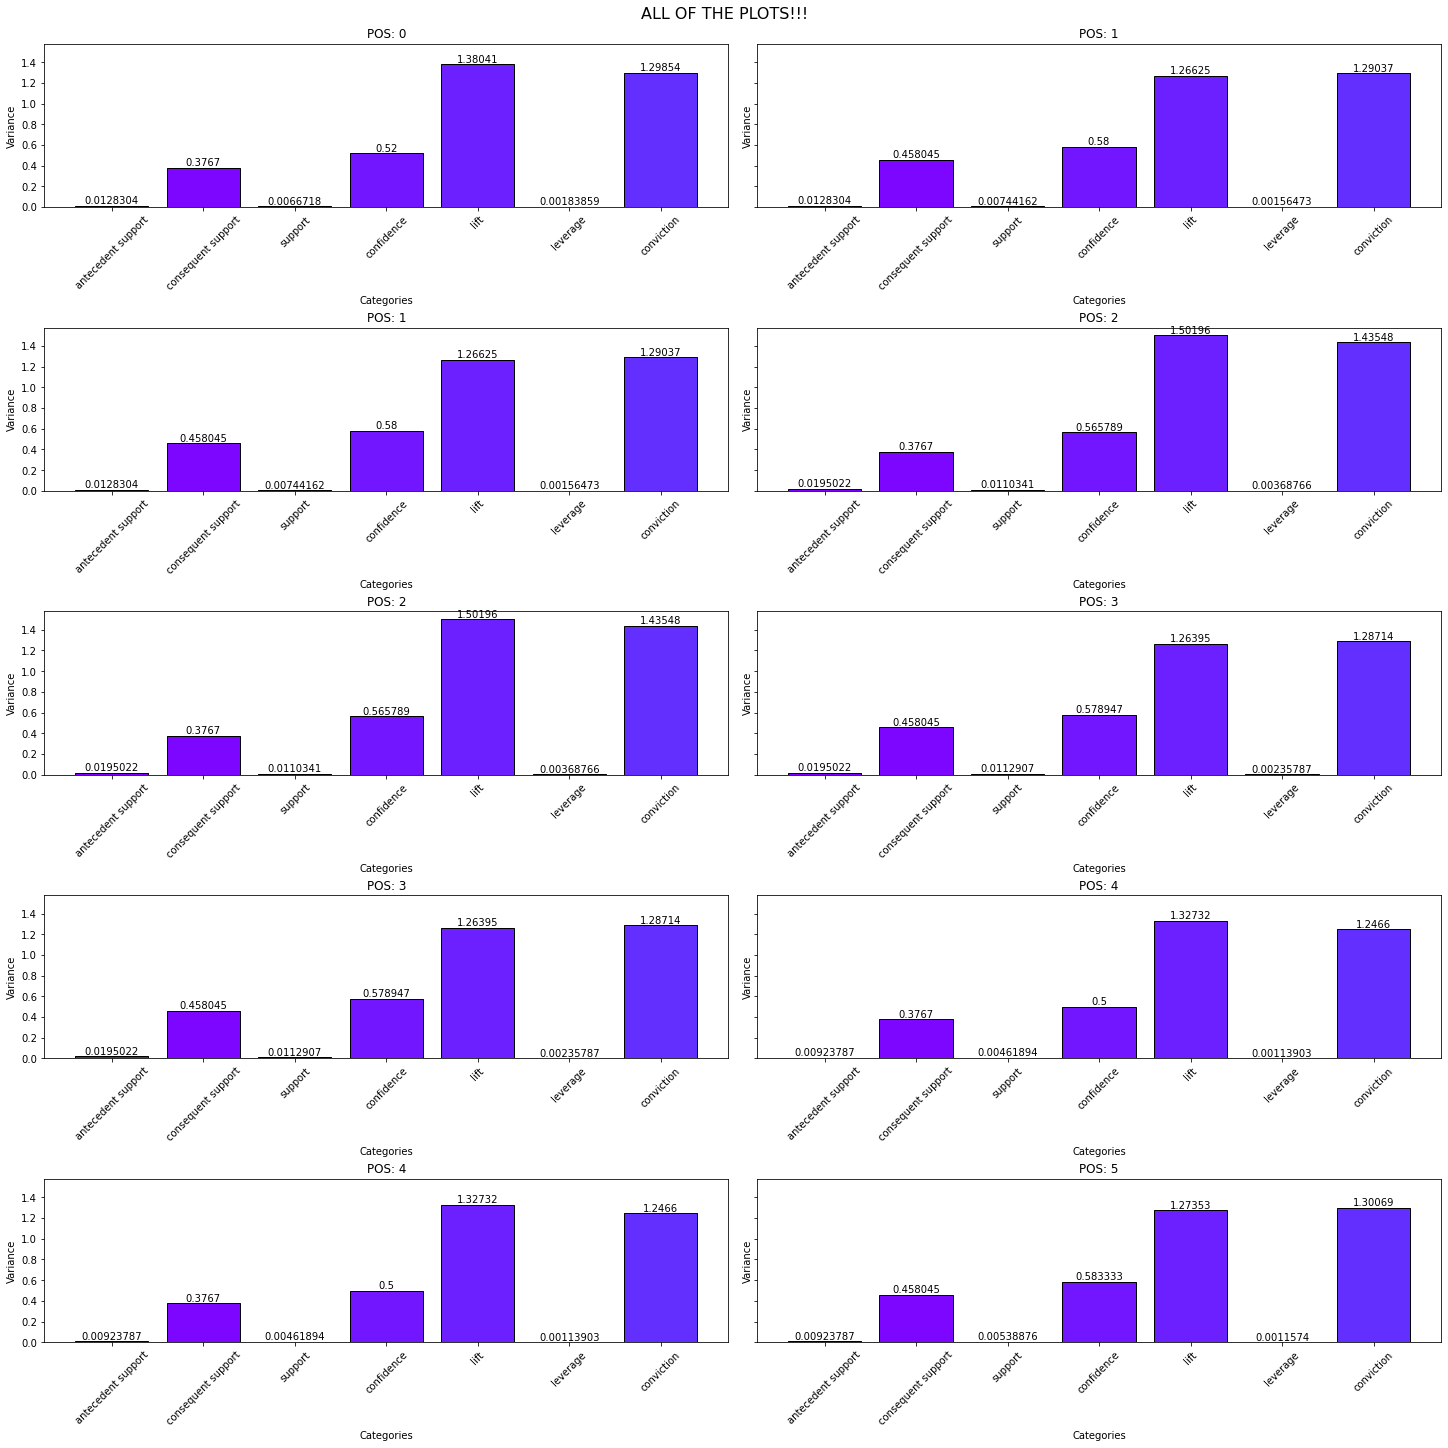

In [20]:
color = plt.cm.rainbow(np.linspace(0, 1, 100))
x = np.linspace(0.0,2.0, 501)

fig6, axes = plt.subplots(5,2,constrained_layout=True, sharey=True,figsize=(20,20))
for i in range(5):
    p1 = axes[i][0].bar(column1,query_smaller.iloc[i].to_list(),color=color,edgecolor='black')
    axes[i][0].set_title("POS: "+str(i))
    axes[i][0].set_xlabel('Categories')
    axes[i][0].set_ylabel('Variance')
    axes[i][0].tick_params(axis='x',rotation=45)
    axes[i][0].bar_label(p1, label_type='edge')
    p2 = axes[i][1].bar(column1,query_smaller.iloc[i+1].to_list(),color=color,edgecolor='black')
    axes[i][1].set_title("POS: "+str(i+1))
    axes[i][1].set_xlabel('Categories')
    axes[i][1].set_ylabel('Variance')
    axes[i][1].tick_params(axis='x',rotation=45)
    axes[i][1].bar_label(p2,label_type='edge')

fig6.suptitle("ALL OF THE PLOTS!!!",fontsize=16)

In [21]:
df[df['antecedents'] == {'rolls/buns', 'Instant food products'}]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [22]:
df['antecedent_len'] = df['antecedents'].apply(lambda x: len(x))
df.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
0,(instant food products),(soda),0.015396,0.313318,0.007955,0.516667,1.649017,0.003131,1.420722,1
1,(instant food products),(whole milk),0.015396,0.458045,0.007955,0.516667,1.127983,0.000903,1.121287,1
2,(uht-milk),(whole milk),0.078522,0.458045,0.040544,0.516340,1.127270,0.004577,1.120529,1
3,(abrasive cleaner),(rolls/buns),0.005645,0.349756,0.002823,0.500000,1.429567,0.000848,1.300488,1
4,(artif. sweetener),(other vegetables),0.007442,0.376700,0.003849,0.517241,1.373086,0.001046,1.291121,1


In [23]:
df.tail()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
24247,"(sausage, rolls/buns, other vegetables, whole ...",(root vegetables),0.003849,0.230690,0.002566,0.666667,2.889878,0.001678,2.307929,6
24248,"(sausage, rolls/buns, root vegetables, other v...",(soda),0.003336,0.313318,0.002566,0.769231,2.455112,0.001521,2.975622,6
24249,"(sausage, rolls/buns, root vegetables, other v...",(bottled water),0.003336,0.213754,0.002566,0.769231,3.598670,0.001853,3.407065,6
24250,"(sausage, root vegetables, other vegetables, w...",(rolls/buns),0.003336,0.349756,0.002566,0.769231,2.199334,0.001399,2.817723,6
24251,"(sausage, rolls/buns, root vegetables, whole m...",(other vegetables),0.003079,0.376700,0.002566,0.833333,2.212193,0.001406,3.739800,6


In [24]:
df['consequent_len'] = df['consequents'].apply(lambda x: len(x))
df.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequent_len
0,(instant food products),(soda),0.015396,0.313318,0.007955,0.516667,1.649017,0.003131,1.420722,1,1
1,(instant food products),(whole milk),0.015396,0.458045,0.007955,0.516667,1.127983,0.000903,1.121287,1,1
2,(uht-milk),(whole milk),0.078522,0.458045,0.040544,0.516340,1.127270,0.004577,1.120529,1,1
3,(abrasive cleaner),(rolls/buns),0.005645,0.349756,0.002823,0.500000,1.429567,0.000848,1.300488,1,1
4,(artif. sweetener),(other vegetables),0.007442,0.376700,0.003849,0.517241,1.373086,0.001046,1.291121,1,1


In [25]:
df.tail()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequent_len
24247,"(sausage, rolls/buns, other vegetables, whole ...",(root vegetables),0.003849,0.230690,0.002566,0.666667,2.889878,0.001678,2.307929,6,1
24248,"(sausage, rolls/buns, root vegetables, other v...",(soda),0.003336,0.313318,0.002566,0.769231,2.455112,0.001521,2.975622,6,1
24249,"(sausage, rolls/buns, root vegetables, other v...",(bottled water),0.003336,0.213754,0.002566,0.769231,3.598670,0.001853,3.407065,6,1
24250,"(sausage, root vegetables, other vegetables, w...",(rolls/buns),0.003336,0.349756,0.002566,0.769231,2.199334,0.001399,2.817723,6,1
24251,"(sausage, rolls/buns, root vegetables, whole m...",(other vegetables),0.003079,0.376700,0.002566,0.833333,2.212193,0.001406,3.739800,6,1


In [26]:
df['consequents'].value_counts()

(whole milk)               10108
(other vegetables)          5942
(rolls/buns)                3672
(soda)                      1894
(yogurt)                    1519
(root vegetables)            294
(sausage)                    212
(bottled water)              202
(tropical fruit)             135
(shopping bags)               64
(citrus fruit)                42
(pip fruit)                   30
(pastry)                      28
(canned beer)                 25
(bottled beer)                18
(brown bread)                 13
(pork)                        12
(frankfurter)                 11
(whipped/sour cream)           9
(newspapers)                   8
(domestic eggs)                3
(white bread)                  3
(beef)                         2
(dessert)                      2
(butter)                       1
(curd)                         1
(fruit/vegetable juice)        1
(margarine)                    1
Name: consequents, dtype: int64

In [27]:
ant_select = df['antecedent_len'] <= 2

In [28]:
df[ant_select]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequent_len
0,(instant food products),(soda),0.015396,0.313318,0.007955,0.516667,1.649017,0.003131,1.420722,1,1
1,(instant food products),(whole milk),0.015396,0.458045,0.007955,0.516667,1.127983,0.000903,1.121287,1,1
2,(uht-milk),(whole milk),0.078522,0.458045,0.040544,0.516340,1.127270,0.004577,1.120529,1,1
3,(abrasive cleaner),(rolls/buns),0.005645,0.349756,0.002823,0.500000,1.429567,0.000848,1.300488,1,1
4,(artif. sweetener),(other vegetables),0.007442,0.376700,0.003849,0.517241,1.373086,0.001046,1.291121,1,1
...,...,...,...,...,...,...,...,...,...,...,...
3924,"(whipped/sour cream, white wine)",(whole milk),0.007442,0.458045,0.003849,0.517241,1.129238,0.000441,1.122622,2,1
3925,"(whipped/sour cream, yogurt)",(whole milk),0.047986,0.458045,0.027714,0.577540,1.260882,0.005734,1.282856,2,1
3926,"(white bread, yogurt)",(whole milk),0.028483,0.458045,0.016423,0.576577,1.258778,0.003376,1.279937,2,1
3927,"(white wine, yogurt)",(whole milk),0.016423,0.458045,0.009751,0.593750,1.296271,0.002229,1.334044,2,1


In [29]:
df[ant_select]['consequents'].value_counts()

(whole milk)          2080
(other vegetables)     929
(rolls/buns)           505
(soda)                 217
(yogurt)               113
(tropical fruit)        24
(root vegetables)       19
(bottled water)         16
(sausage)               11
(citrus fruit)           6
(pastry)                 5
(pip fruit)              2
(canned beer)            1
(butter)                 1
Name: consequents, dtype: int64

In [30]:
con_select = df['consequent_len'] == 1

In [31]:
df[con_select]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequent_len
0,(instant food products),(soda),0.015396,0.313318,0.007955,0.516667,1.649017,0.003131,1.420722,1,1
1,(instant food products),(whole milk),0.015396,0.458045,0.007955,0.516667,1.127983,0.000903,1.121287,1,1
2,(uht-milk),(whole milk),0.078522,0.458045,0.040544,0.516340,1.127270,0.004577,1.120529,1,1
3,(abrasive cleaner),(rolls/buns),0.005645,0.349756,0.002823,0.500000,1.429567,0.000848,1.300488,1,1
4,(artif. sweetener),(other vegetables),0.007442,0.376700,0.003849,0.517241,1.373086,0.001046,1.291121,1,1
...,...,...,...,...,...,...,...,...,...,...,...
24247,"(sausage, rolls/buns, other vegetables, whole ...",(root vegetables),0.003849,0.230690,0.002566,0.666667,2.889878,0.001678,2.307929,6,1
24248,"(sausage, rolls/buns, root vegetables, other v...",(soda),0.003336,0.313318,0.002566,0.769231,2.455112,0.001521,2.975622,6,1
24249,"(sausage, rolls/buns, root vegetables, other v...",(bottled water),0.003336,0.213754,0.002566,0.769231,3.598670,0.001853,3.407065,6,1
24250,"(sausage, root vegetables, other vegetables, w...",(rolls/buns),0.003336,0.349756,0.002566,0.769231,2.199334,0.001399,2.817723,6,1


In [32]:
df = df[con_select]
df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequent_len
0,(instant food products),(soda),0.015396,0.313318,0.007955,0.516667,1.649017,0.003131,1.420722,1,1
1,(instant food products),(whole milk),0.015396,0.458045,0.007955,0.516667,1.127983,0.000903,1.121287,1,1
2,(uht-milk),(whole milk),0.078522,0.458045,0.040544,0.516340,1.127270,0.004577,1.120529,1,1
3,(abrasive cleaner),(rolls/buns),0.005645,0.349756,0.002823,0.500000,1.429567,0.000848,1.300488,1,1
4,(artif. sweetener),(other vegetables),0.007442,0.376700,0.003849,0.517241,1.373086,0.001046,1.291121,1,1
...,...,...,...,...,...,...,...,...,...,...,...
24247,"(sausage, rolls/buns, other vegetables, whole ...",(root vegetables),0.003849,0.230690,0.002566,0.666667,2.889878,0.001678,2.307929,6,1
24248,"(sausage, rolls/buns, root vegetables, other v...",(soda),0.003336,0.313318,0.002566,0.769231,2.455112,0.001521,2.975622,6,1
24249,"(sausage, rolls/buns, root vegetables, other v...",(bottled water),0.003336,0.213754,0.002566,0.769231,3.598670,0.001853,3.407065,6,1
24250,"(sausage, root vegetables, other vegetables, w...",(rolls/buns),0.003336,0.349756,0.002566,0.769231,2.199334,0.001399,2.817723,6,1


In [33]:
df.drop(columns=['antecedent_len', 'consequent_len'], inplace=True)
df.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(instant food products),(soda),0.015396,0.313318,0.007955,0.516667,1.649017,0.003131,1.420722
1,(instant food products),(whole milk),0.015396,0.458045,0.007955,0.516667,1.127983,0.000903,1.121287
2,(uht-milk),(whole milk),0.078522,0.458045,0.040544,0.516340,1.127270,0.004577,1.120529
3,(abrasive cleaner),(rolls/buns),0.005645,0.349756,0.002823,0.500000,1.429567,0.000848,1.300488
4,(artif. sweetener),(other vegetables),0.007442,0.376700,0.003849,0.517241,1.373086,0.001046,1.291121


In [34]:
df[con_select]['consequents'].value_counts()

(whole milk)               10108
(other vegetables)          5942
(rolls/buns)                3672
(soda)                      1894
(yogurt)                    1519
(root vegetables)            294
(sausage)                    212
(bottled water)              202
(tropical fruit)             135
(shopping bags)               64
(citrus fruit)                42
(pip fruit)                   30
(pastry)                      28
(canned beer)                 25
(bottled beer)                18
(brown bread)                 13
(pork)                        12
(frankfurter)                 11
(whipped/sour cream)           9
(newspapers)                   8
(domestic eggs)                3
(white bread)                  3
(beef)                         2
(dessert)                      2
(butter)                       1
(curd)                         1
(fruit/vegetable juice)        1
(margarine)                    1
Name: consequents, dtype: int64

In [35]:
final_rule = (con_select & ant_select)

In [36]:
df.loc[ ~final_rule]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3929,"(other vegetables, beef, uht-milk)",(whole milk),0.004619,0.458045,0.003593,0.777778,1.698039,0.001477,2.438799
3930,"(beef, whole milk, uht-milk)",(other vegetables),0.006928,0.376700,0.003593,0.518519,1.376476,0.000983,1.294546
3931,"(beef, pip fruit, uht-milk)",(whole milk),0.003593,0.458045,0.002823,0.785714,1.715366,0.001177,2.529125
3932,"(beef, rolls/buns, uht-milk)",(whole milk),0.004619,0.458045,0.003079,0.666667,1.455462,0.000964,1.625866
3933,"(bottled beer, bottled water, uht-milk)",(other vegetables),0.003849,0.376700,0.002566,0.666667,1.769755,0.001116,1.869900
...,...,...,...,...,...,...,...,...,...
24247,"(sausage, rolls/buns, other vegetables, whole ...",(root vegetables),0.003849,0.230690,0.002566,0.666667,2.889878,0.001678,2.307929
24248,"(sausage, rolls/buns, root vegetables, other v...",(soda),0.003336,0.313318,0.002566,0.769231,2.455112,0.001521,2.975622
24249,"(sausage, rolls/buns, root vegetables, other v...",(bottled water),0.003336,0.213754,0.002566,0.769231,3.598670,0.001853,3.407065
24250,"(sausage, root vegetables, other vegetables, w...",(rolls/buns),0.003336,0.349756,0.002566,0.769231,2.199334,0.001399,2.817723


In [37]:
df1 = df.loc[final_rule]

In [38]:
df1.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(instant food products),(soda),0.015396,0.313318,0.007955,0.516667,1.649017,0.003131,1.420722
1,(instant food products),(whole milk),0.015396,0.458045,0.007955,0.516667,1.127983,0.000903,1.121287
2,(uht-milk),(whole milk),0.078522,0.458045,0.040544,0.516340,1.127270,0.004577,1.120529
3,(abrasive cleaner),(rolls/buns),0.005645,0.349756,0.002823,0.500000,1.429567,0.000848,1.300488
4,(artif. sweetener),(other vegetables),0.007442,0.376700,0.003849,0.517241,1.373086,0.001046,1.291121


In [39]:
df1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(instant food products),(soda),0.015396,0.313318,0.007955,0.516667,1.649017,0.003131,1.420722
1,(instant food products),(whole milk),0.015396,0.458045,0.007955,0.516667,1.127983,0.000903,1.121287
2,(uht-milk),(whole milk),0.078522,0.458045,0.040544,0.516340,1.127270,0.004577,1.120529
3,(abrasive cleaner),(rolls/buns),0.005645,0.349756,0.002823,0.500000,1.429567,0.000848,1.300488
4,(artif. sweetener),(other vegetables),0.007442,0.376700,0.003849,0.517241,1.373086,0.001046,1.291121
...,...,...,...,...,...,...,...,...,...
3924,"(whipped/sour cream, white wine)",(whole milk),0.007442,0.458045,0.003849,0.517241,1.129238,0.000441,1.122622
3925,"(whipped/sour cream, yogurt)",(whole milk),0.047986,0.458045,0.027714,0.577540,1.260882,0.005734,1.282856
3926,"(white bread, yogurt)",(whole milk),0.028483,0.458045,0.016423,0.576577,1.258778,0.003376,1.279937
3927,"(white wine, yogurt)",(whole milk),0.016423,0.458045,0.009751,0.593750,1.296271,0.002229,1.334044


In [40]:
df1['consequents'].value_counts()

(whole milk)          2080
(other vegetables)     929
(rolls/buns)           505
(soda)                 217
(yogurt)               113
(tropical fruit)        24
(root vegetables)       19
(bottled water)         16
(sausage)               11
(citrus fruit)           6
(pastry)                 5
(pip fruit)              2
(canned beer)            1
(butter)                 1
Name: consequents, dtype: int64

In [41]:
df.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(instant food products),(soda),0.015396,0.313318,0.007955,0.516667,1.649017,0.003131,1.420722
1,(instant food products),(whole milk),0.015396,0.458045,0.007955,0.516667,1.127983,0.000903,1.121287
2,(uht-milk),(whole milk),0.078522,0.458045,0.040544,0.516340,1.127270,0.004577,1.120529
3,(abrasive cleaner),(rolls/buns),0.005645,0.349756,0.002823,0.500000,1.429567,0.000848,1.300488
4,(artif. sweetener),(other vegetables),0.007442,0.376700,0.003849,0.517241,1.373086,0.001046,1.291121


In [42]:
# df.to_csv('Data/master_rules.csv', index=False)

In [43]:
print("DONE")

DONE
